In [13]:
from GaussianGenerator import GaussianGenerator
import numpy as np
import threading
import communicator
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import socket
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def GaussianGenerator (n1, n2):
	mean1 = [3, 6]
	cov1 = [[1,0], [0,1]]
	x1 = np.random.multivariate_normal(mean1,cov1, n1)
	y1 = np.ones(n1)
	
	mean2 = [-1,0]
	cov2 = [[2,0],[0,2]]
	x2 = np.random.multivariate_normal(mean2,cov2, n2)
	y2 = -np.ones(n2)
	
	plt.plot(x1[:,0], x1[:,1], 'x')
	plt.plot(x2[:,0], x2[:,1], '*')
	#plt.show()
	plt.savefig("gaussian.png")
	

	X = np.concatenate((x1,x2), axis = 0)
	Y = np.concatenate((y1,y2), axis = 0)
	return X,Y

In [3]:
DEBUG = True
BACKLOG = 5
HEADERSIZE = 10


class Server:

	def __init__(self, port):
		"""
		Server object that can accept request at port=port
		Create a SOCK_STREAM socket and bind at localhost at port
		"""
		self.s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
		self.s.bind((socket.gethostname(), port))
		self.s.listen(BACKLOG)  # backlog = 5 by default
		self.clientsock = None
		self.clientaddress = None

	def recv(self):
		"""
		Blocking recv. Block to accept and receive.
		:return: msg to be pickled
		"""
		self.clientsock, self.clientaddress = self.s.accept()

		#if DEBUG:
			#print(f"Received message from {self.clientaddress}")

		full_msg = b''
		new_msg = True
		msglen = 0
		while True:  # receive full length
			msg = self.clientsock.recv(16)
			if new_msg:
				#print("new msg len:", msg[:HEADERSIZE])
				msglen += int(msg[:HEADERSIZE])
				new_msg = False
			full_msg += msg
			if len(full_msg) - HEADERSIZE == msglen:
				#print("full msg recvd")
				return pickle.loads(full_msg[HEADERSIZE:])

	def reply(self, msg, port):
		"""
		Reply to msg that we just received from
		:return: num_byte_sent
		"""
		
		loc = (self.clientaddress[0],port)
		#print(loc)
		return self.send(loc, msg)

	def get_socket(self):
		return self.s

	def send(self, location: (str, str), msgtosend):
		"""
		Send msg to location
		:param location: specify (address, port) to be sent to
		:param msgtosend: the msg will be pickled
		:return:
		"""
		s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
		s.connect(location)
		msg = pickle.dumps(msgtosend)
		msg = bytes(f"{len(msg):<{HEADERSIZE}}", 'utf-8') + msg
		return s.send(msg)


In [4]:
PORT = 1232
serv_model = Server(PORT)
PORT2 = 1233
serv_grad = Server(PORT2)

In [5]:
def model_server():
	print("model server thread is up")
	global w
	while True:
		result = serv_model.recv()
		#print(f"Received obj of type {str(type(result))} and content:\n{str(result)}")
		
		#send weights
		serv_model.reply(w, PORT)
		#print(f"Sent obj of type {str(type(w))} and content:\n{str(w)}")

In [6]:
def show_image(X, Y, w):
	fig = plt.figure()
	plt.scatter(X[:,1], X[:,2], c=Y)
	z1 = np.linspace(-6,6,100)
	z2 = - w[1]/w[2]*z1 - w[0]/w[2]
	plt.plot(z1, z2, '-g')
	plt.ylim(-4,8)
	plt.xlim(-6,6)
	plt.show() 

In [7]:
def show_mal_image(X, Y, w1, w2):
	fig = plt.figure()
	plt.scatter(X[:,1], X[:,2], c=Y)
	z1 = np.linspace(-6,6,100)
	z2 = - w1[1]/w1[2]*z1 - w1[0]/w1[2]
	plt.plot(z1, z2, '-g')
	z3 = - w2[1]/w2[2]*z1 - w2[0]/w2[2]
	plt.plot(z1, z3, '-r')
	plt.ylim(-4,8)
	plt.xlim(-6,6)
	plt.show() 

In [36]:
def show_vectors(v,g):
    fig = plt.figure()
    ax = fig.gca(projection = '3d')
    ax.quiver(0,0,0,v[0],v[1],v[2], color = "green", label="v")
    ax.quiver(0,0,0,g[0],g[1],g[2], color = "blue", label="g")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    plt.legend()
    plt.show()

In [8]:
def ClassAccuracy(X,Y,w):
	s = 0
	for i in range(X.shape[0]):
		if ((np.dot(w,X[i])>=0 and Y[i]==1) or (np.dot(w,X[i])<0 and Y[i]==-1)):
			s += 1
	s = s/X.shape[0]
	return s

In [10]:
X, Y = GaussianGenerator(20,20)
x_temp = np.ones((40,1))
X = np.concatenate((x_temp,X),axis = 1)

# Zeno++

model server thread is upGrad from updater is [ 0.5        -0.47047846  0.38546227]

Received gradient [-122.31313883 -116.88066122 -161.36014795]


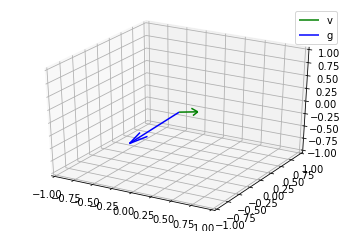

Score is -0.02426360029562262 and threshold -0.010000000000000002
Rejected gradient



<ipython-input-7-bf9cd10d559c>:5: RuntimeWarning: invalid value encountered in double_scalars
  z2 = - w1[1]/w1[2]*z1 - w1[0]/w1[2]


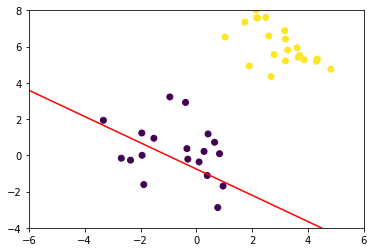

Received gradient [-155.6783876   -37.65931271  110.48607327]


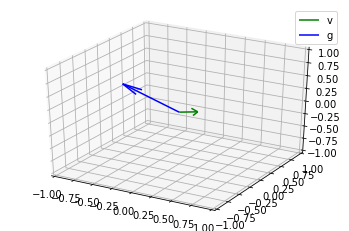

Score is -0.008334547775211957 and threshold -0.010000000000000002
New weights are [ 0.06299457  0.01523867 -0.0447077 ]


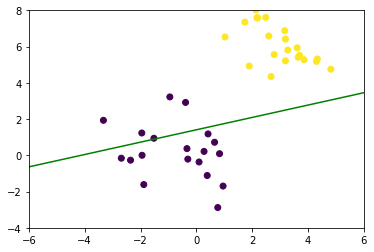

Received gradient [0. 0. 0.]


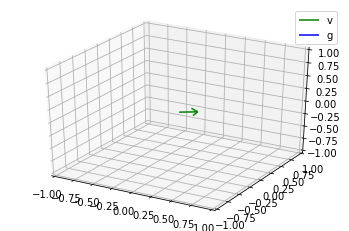

Score is 0.0 and threshold -0.010000000000000002
New weights are [ 0.06299457  0.01523867 -0.0447077 ]


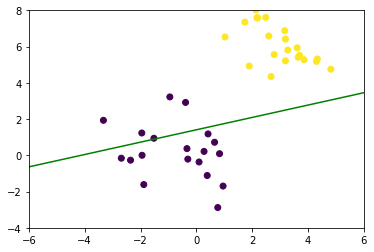

Grad from updater is [-0.2        -1.60686736 -3.41445954]
Received gradient [0. 0. 0.]


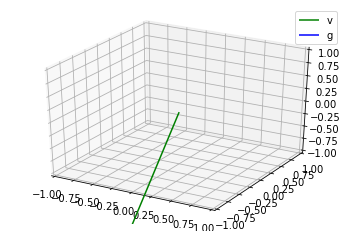

Score is 0.0 and threshold -0.010000000000000002
New weights are [ 0.06299457  0.01523867 -0.0447077 ]


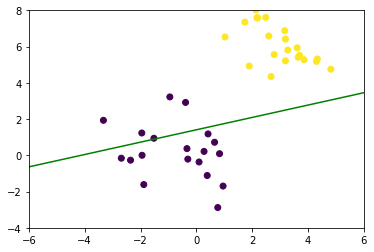

Received gradient [87.30450391 51.11269317 25.19738847]


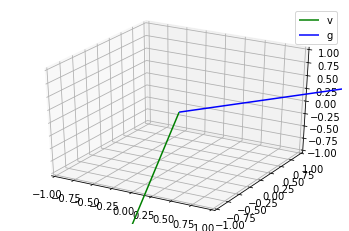

Score is -0.7013993799543313 and threshold -0.010000000000000002
Rejected gradient



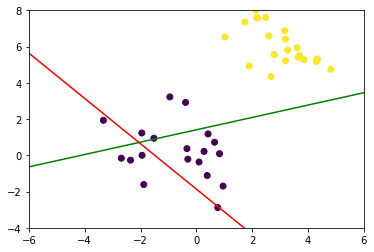

Received gradient [0. 0. 0.]


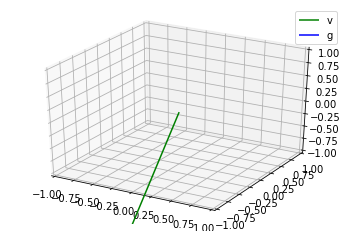

Score is 0.0 and threshold -0.010000000000000002
New weights are [ 0.06299457  0.01523867 -0.0447077 ]


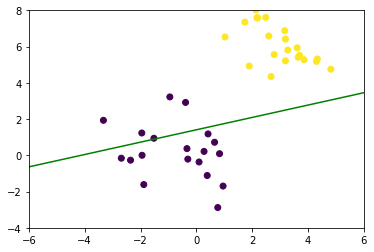

Grad from updater is [ 0.4        -1.116241   -2.51994781]
Received gradient [-0.2        -1.69522586 -3.08464349]


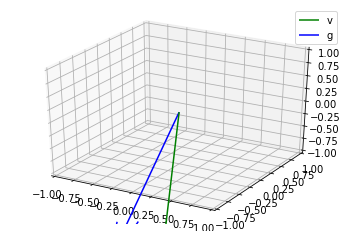

Score is 0.74170217723856 and threshold -0.010000000000000002
New weights are [0.07879386 0.14915553 0.19896825]


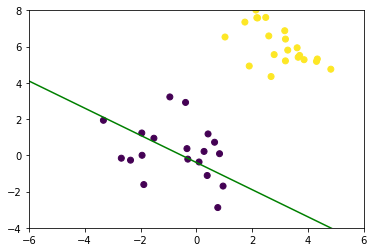

Received gradient [ 0.1        -0.14720276  0.16555933]


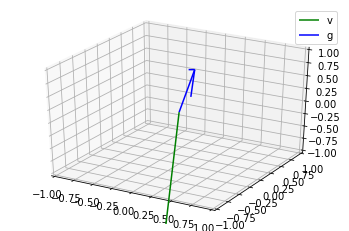

Score is -0.25943768054015354 and threshold -0.010000000000000002
Rejected gradient



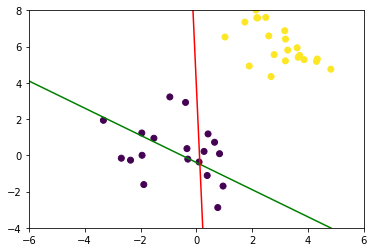

Received gradient [ 0.3        -0.20796218  0.39203761]


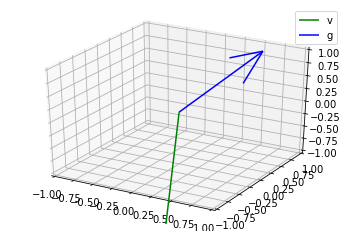

Score is -0.3460579264567845 and threshold -0.010000000000000002
Rejected gradient



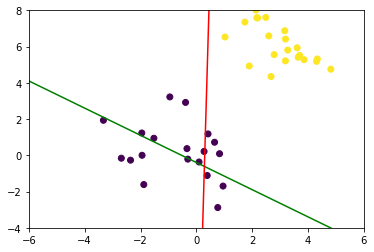

Grad from updater is [ 0.2        -0.11020982  0.21225819]
Received gradient [ 0.1        -0.14854758  0.15295449]


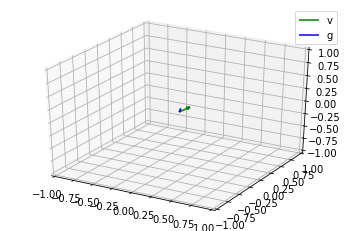

Score is 0.00891858017186545 and threshold -0.010000000000000002
New weights are [0.06555542 0.16882092 0.17871945]


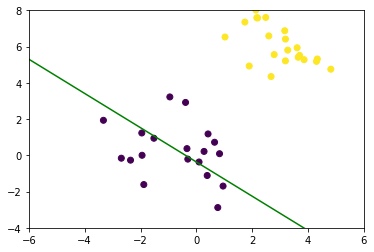

In [40]:
maxit = 10
k = 3
ns = 10
gamma = 0.1
epsilon = 0.1
rho = 0.002


step = 0
w = np.array([0.0,0.0,0.0])
th = threading.Thread(target=model_server, daemon=True)
th.start()

while (step < maxit):
    if (step%k==0):
        #updater
        r = np.random.choice(range(X.shape[0]), ns)
        x = X[r]
        y = Y[r]

        v = np.array([0,0,0])
        for i in range(ns):
            if ((np.dot(w,x[i])>=0 and y[i]==-1) or (np.dot(w,x[i])<0 and y[i]==1)):
                v = v -np.multiply(y[i],x[i])
        v = v/ns
        print(f"Grad from updater is {str(v)}")

    
    g_tilde = serv_grad.recv()
    print(f"Received gradient {str(g_tilde)}")
    
    if (np.linalg.norm(g_tilde)!= 0):
        c = np.linalg.norm(v)/np.linalg.norm(g_tilde)
        g = [c*e for e in g_tilde]
    else:
        g = g_tilde
    show_vectors(v,g)   
    s = gamma*np.dot(v,g)-rho*(np.linalg.norm(g)**2)
    threshold = -gamma*epsilon
    print(f"Score is {str(s)} and threshold {str(threshold)}")
    if (s>=threshold):
        u_g = np.array([gamma*e for e in g])  
        w = w - u_g
        print(f"New weights are {str(w)}")
        show_image(X, Y, w)
    else:
        print("Rejected gradient\n")
        u_g = np.array([gamma*e for e in g])
        w2 = w - u_g
        show_mal_image(X, Y, w, w2)

    step += 1